In [105]:
from chirho_diffeqpy import DiffEqPy, ATempParams
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import simulate
from chirho.dynamical.handlers.trajectory import LogTrajectory
from chirho.dynamical.handlers import StaticBatchObservation, StaticIntervention, DynamicIntervention
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.observational.handlers import condition
from chirho.dynamical.ops import State
import numpy as np
import torch
from pyro import sample, set_rng_seed
from pyro.distributions import Uniform, Poisson
from typing import Tuple, Optional, Union, Callable
from functools import partial
from numbers import Real
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta, AutoMultivariateNormal
from contextlib import nullcontext
# The DiffEqPy backend interfaces with julia, so we must load a julia<>python interop backend.
import chirho_diffeqpy.lang_interop.julianumpy
from contextlib import ExitStack, nullcontext
from pyro.contrib.autoname import scope
# Global params are weird.
from functools import singledispatch, partial
pyro.settings.set(module_local_params=True)
torch.set_default_dtype(torch.float64)

# System Definition

### Internal Stuff

This section employs effectful programming for easier hot-swapping of virtual fish dynamics and solver backends. It's not necessary to understand this code to understand the rest of the notebook.

In [106]:
# Effectful virtual fish function for easy hot-swapping.
class NoVirtualFish(NotImplementedError):
    pass

# noinspection PyProtectedMember
@pyro.poutine.runtime.effectful(type="virtual_fish_dynamics")
def virtual_fish_dynamics(state, atemp_params):
    raise NoVirtualFish()


class VirtualFishTrajectory(pyro.poutine.messenger.Messenger):
    def __init__(self, virtual_fish_dynamics_fn, initial_state, atemp_params):
        self.virtual_fish_dynamics_fn = virtual_fish_dynamics_fn
        self.initial_state = initial_state
        self.atemp_params = atemp_params
        super().__init__()

    def _pyro_virtual_fish_dynamics(self, msg: dict) -> None:
        msg["value"] = self.virtual_fish_dynamics_fn(*msg["args"], **msg["kwargs"])
        msg["done"] = True
    
    def _pyro_simulate(self, msg: dict) -> None:
        # Add the virtual fish parameters and starting state that are associated with the passed trajectory function.
        og_atemp_params = msg["kwargs"].pop("atemp_params")
        og_initial_state = msg["args"][1]
        
        atemp_params = dict(**og_atemp_params, **self.atemp_params)
        initial_state = dict(**og_initial_state, **self.initial_state)
        
        msg["kwargs"]["atemp_params"] = atemp_params
        msg["args"] = (msg["args"][0], initial_state, *msg["args"][2:])


# TorchDiffEq backend interoperation.
class PureTorchDiffEq(TorchDiffEq):

    # noinspection PyFinal
    def _pyro_simulate(self, msg: dict) -> None:
        atemp_params = msg["kwargs"].pop("atemp_params", None)
        dynamics = msg["args"][0]
        if atemp_params is None:
            raise ValueError("PureTorchDiffEq requires atemp_params to be passed into simulate as a keyword argument.")
        
        print("params", atemp_params)
        print("u0", msg["args"][1])

        closure_dynamics = partial(dynamics, atemp_params=atemp_params)
        msg["args"] = (closure_dynamics, *msg["args"][1:])

        return super()._pyro_simulate(msg)
    

@singledispatch
def sin(x):
    return np.sin(x)

@sin.register(torch.Tensor)
def _(x):
    return torch.sin(x)


@singledispatch
def cos(x):
    return np.cos(x)

@cos.register(torch.Tensor)
def _(x):
    return torch.cos(x)

In [107]:
# SOLVER = PureTorchDiffEq()
SOLVER = DiffEqPy()

### Virtual Fish Definitions

In [108]:
def sinusoidal_virtual_fish(state, atemp_params):
    
    assert 'vfish_theta' in state
    
    frequency = atemp_params['frequency']
    amplitude = atemp_params['amplitude']
    phase = atemp_params['phase']
    t = state['t']
    
    return dict(
        vfish_theta=amplitude * frequency * cos(frequency * t + phase)
    )

# TODO others...

### General, Multi-Fish System Dynamics

In [109]:
def pure_schooling_dynamics(state, atemp_params):
    thetas = state['thetas']
    
    # Compute the virtual fish dynamics and distance to real fish.
    try:
        # ...if the virtual fish is present.
        ddt_vfish = virtual_fish_dynamics(state, atemp_params)
        vfish_theta = state['vfish_theta']
        virtual_fish_diff = vfish_theta - thetas
    except NoVirtualFish:
        # ...otherwise proceed with no virtual fish.
        ddt_vfish = dict()
        virtual_fish_diff = 0.0
    
    # Compute the distances between the real fish and virtual fish.
    thetas_diff_mat = thetas[..., :, None] - thetas[..., None, :]
    thetas_diff_tots = thetas_diff_mat.sum(axis=-2) + virtual_fish_diff
    assert thetas.shape == thetas_diff_tots.shape
    
    # And the resulting dynamics.
    copy_coefs = atemp_params['copy_coefs']
    dthetas = thetas_diff_tots * copy_coefs
    
    return dict(
        thetas=dthetas,
        **ddt_vfish
    )

### Default Experiment Simulation

In [110]:
START_T = torch.tensor(0.0)
END_T = torch.tensor(5.0)
RES = 50
GET_TRUE_COPY_COEFS = lambda: torch.tensor([1., 2.])

def run_experiment(logging_times, initial_state, atemp_params):
    with LogTrajectory(times=logging_times) as logging_trajectory:
        simulate(
            pure_schooling_dynamics,
            initial_state,
            START_T,
            END_T,
            atemp_params=atemp_params
        )
    return logging_trajectory.trajectory

### Mesoscopic Observations

In [114]:
def polarization_fn(theta):
    theta = theta.T
    assert theta.shape[-1] == 2, "Multi-fish polarization is not yet implemented!"
    return torch.sqrt((1+torch.cos(theta[...,0]-theta[...,1]))/2)

# Inference Under Non-Identification

In [117]:
def copy_coefficient_prior(num_fish: int):
    with pyro.plate("fish_plate", size=num_fish, dim=-1):
        return sample("copy_coefs", dist.Uniform(0., 10.))

def experimental_meta_model(num_fish: int = 2, experimental_contexts: Tuple = ()):
    copy_coefs = copy_coefficient_prior(num_fish)
    
    fixed_initial_state = dict(
        thetas=torch.linspace(0., torch.pi, num_fish)
    )
    
    fixed_observation_times = torch.linspace(START_T, END_T, RES)
    
    observed_polarizations = []
    trajectories = []
    
    for i, experimental_context in enumerate(experimental_contexts):
        
        with SOLVER, scope(prefix=f"experiment{i}"), experimental_context:
            trajectory = run_experiment(
                logging_times=fixed_observation_times,
                initial_state=fixed_initial_state,
                atemp_params=dict(
                    copy_coefs=copy_coefs
                )
            )
            
            polarization = polarization_fn(trajectory['thetas'])
            # A trivial noise model over the polarization. This largely functions to relax the problem for inference.
            observed_polarization = pyro.sample("polarization", dist.Normal(polarization, 0.001))
            
            trajectories.append(trajectory)
            observed_polarizations.append(observed_polarization)
    
    return trajectories, observed_polarizations
    

### Simulation Example

In [118]:
def simple_experimental_pair():
    num_fish = 2
    
    contexts = (
        # No virtual fish.
        nullcontext(),
        
        # Simple sinusoidal virtual fish.
        VirtualFishTrajectory(
            sinusoidal_virtual_fish,
            initial_state=dict(
                vfish_theta=torch.tensor(torch.pi/2.)
            ),
            atemp_params=dict(
                frequency=torch.tensor(1.),
                amplitude=torch.tensor(1.),
                phase=torch.tensor(0.)
            )
        )
    )
    
    return experimental_meta_model(num_fish, contexts)

In [119]:
def plot_simple_experimental_pair():
    with condition(data=dict(copy_coefs=GET_TRUE_COPY_COEFS())):
        trajectories, observed_polarizations = simple_experimental_pair()
    
    for i, trajectory in enumerate(trajectories):
        plt.figure()
        plt.suptitle(f"Fish Thetas {i}")
        plt.plot(trajectory['thetas'].detach().numpy().T)
        if 'vfish_theta' in trajectory:
            plt.plot(trajectory['vfish_theta'].detach().numpy(), label='vfish_theta', linestyle="--")
        
    plt.figure()
    plt.suptitle("Polarizations")
    for i, polarization in enumerate(observed_polarizations):
        plt.plot(polarization.detach().numpy(), label=f"Experiment {i}")
    plt.legend()
    
    plt.show()

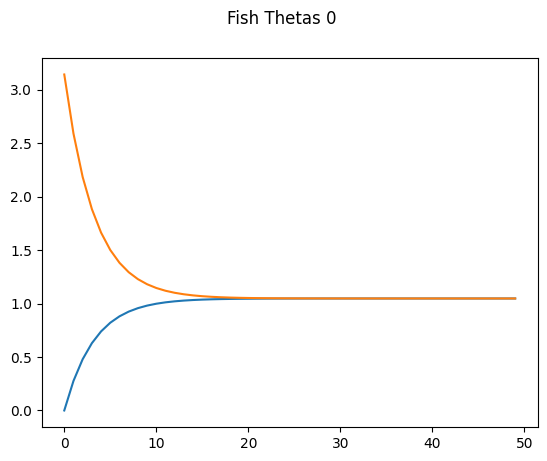

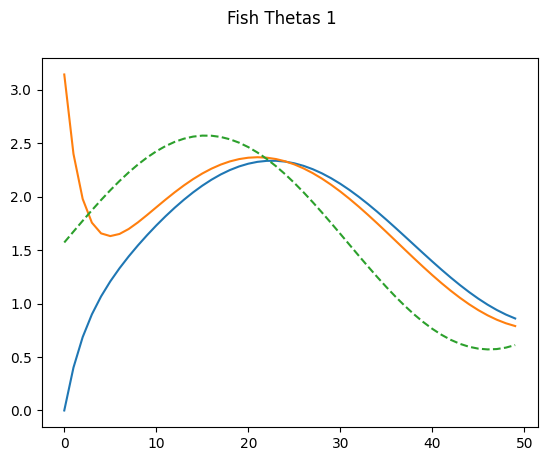

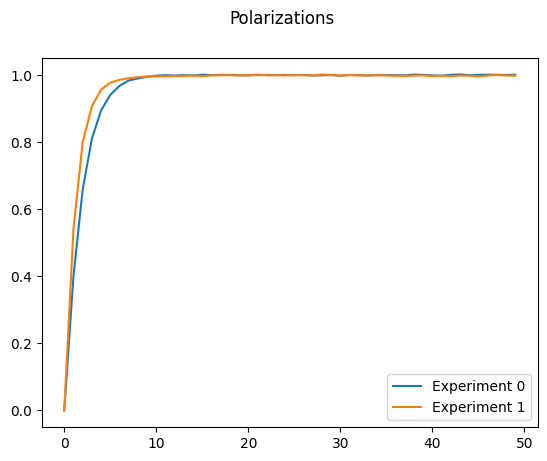

In [120]:
plot_simple_experimental_pair()